# Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
import helpers
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Use of machine learning techniques for heavenly bodies classification based on Sloan Digital Sky Survey

## Wprowadzenie
W tym notebooku spróbujemy przeprowadzić klasyfikację obiektów niebieskich jako gwiazdę, galaktykę lub kwazar. W tym celu spróbujemy kompletnego pojjścia jakim kierują się ludzie z dziłu tzw. Data Science. Na to podejście będzie się analiza danych, wybór cech, proces uczenia maszynowego wraz z selekcją cech oraz analiza otrzymanych wyników.

Cały proces zostanie przeprowadzony na zbiorze Sloan Digital Sky Survey.
### O zbiorze danych

Sloan Digital Sky Survey jest projektem, który oferuje publicznie dostępne dane o obserwacjach obiektów niebieskich. Dane te były zbierane od 1998r. i zostały udostępnione dla każdego, kto był zainteresowany.

Dla tego celu wykorzystany został specjalny teleskop od średnicy 2.5m, który zbudowano w Nowym Meksyku w obserwatorium Apache Point Observatory w USA. Teleskop używa kamery składającej się z 30 chipów CCD o rozdzielczości 2048x2048 każdy. Chipy są ułożone w 5 rzędów po 6 w każdym.Każdy rząd obserwuje przestrzeń kosmiczną przez zróżne optyczne filtry (u, g, r, i, z) w różnych długościach fal - 354, 476, 628, 769, 925 nm.

Teleskop pokrywa swym zasięgiem około 1/4 ziemskiego nieba - przez co skupia swój wzork na północnej części nieba.


## Opis Zbioru Danych

### Zawartość
Zbiór składa się z 10 tys. obserwacji ciał niebieskich zebranych przez SDSS. Każda obserwacja jest opisana przez 17 atrybutów i jednej klasy przynależności - gwiazda, galaktyka lub kwazar.

### Opis cech

Zbiór powstał poprzez wykonaie kwerendy, która łączy ze sobą dwa widoki SQL. "PhotoObj", który zawiera fotometryczne dane oraz "SpecObj" zawierający dane spektralne.

View "PhotoObj"<br>
* **objid = Object Identifier**<br>
* **ra = J2000 Right Ascension (r-band)**<br>
* **dec = J2000 Declination (r-band)**<br>

Rektascensja, α (łac. recta ascensio – "wznoszenie proste") – jedna ze współrzędnych astronomicznych, określających położenie ciała niebieskiego na sferze niebieskiej w układzie współrzędnych astronomicznych zwanym układem równikowym równonocnym.

Definiujemy ją jako kąt dwuścienny pomiędzy płaszczyzną koła godzinnego punktu równonocy wiosennej (rektascensja równa 0h) a płaszczyzną koła godzinnego obiektu. Rektascensję nalicza się w kierunku na wschód, zgodnym z rocznym ruchem Słońca. Przyjmuje ona wartości z zakresu od 0h do 24h.

Współrzędna ta nie ulega zmianie na skutek ruchu obrotowego Ziemi, jak w przypadku kąta godzinnego. Zmianę współrzędnych, w tym deklinacji, powoduje precesja (ruch punktu Barana).

Deklinacja (łac. declinatio – „odchylenie”, oznaczana symbolem δ) – jedna ze współrzędnych określających położenie ciała w obydwu układach równikowych: równonocnym i godzinnym. Definiujemy ją jako kąt pomiędzy kierunkiem poprowadzonym od obserwatora do obiektu a płaszczyzną równika niebieskiego. Obiekty położone na północnej półkuli nieba mają deklinację dodatnią (od 0° do 90°), a na południowej ujemną (od 0° do -90°).

Zjawisko precesji skutkuje powolną zmianą współrzędnych astronomicznych (w tym rektascensji). Dlatego też oprócz nich podaje się również epokę, dla której zostały one wyznaczone (np. J2000.0).

Source: https://en.wikipedia.org/wiki/Right_ascension

u = better of DeV/Exp magnitude fit
g = better of DeV/Exp magnitude fit
r = better of DeV/Exp magnitude fit
i = better of DeV/Exp magnitude fit
z = better of DeV/Exp magnitude fit
The Thuan-Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further education: https://www.astro.umd.edu/~ssm/ASTR620/mags.html
<br>
* **run = Run Number**<br>
* **rereun = Rerun Number**<br>
* **camcol = Camera column**<br>
* **field = Field number**<br>

run, rerun, camcol oraz field są cechami, które opisują pole wewnątrz obrazu wykonanego przez SDSS. Pole jest po porstu częścią całego obrazu odpowiadającego 2048x1489 pikseli. Pole może być identyfikowane przez: 
* run number - identyfikator skanu,
* camcol - kolumna kamery, numer od 1 do 6, które identyfikujące linię skanu oraz 
* field - numer pola. Numer pola zazwyczaj zaczyna się na 11 (po początkowym okresie wznoszenia) i może osiągnąć wartość 800 dla wyjątkowo długich obserwacji.
* dodatkowo numer rerun, oznacza jak obraz był przetwarzany

View "SpecObj"<br>
* **specobjid = Object Identifier**<br>
* **class = object class (galaxy, star or quasar object)**<br>
Class identyfikuje objekt jako gwiazdę, galaktykę lub kawazar. Jest to zmienna, którą będziemy chcieli przewidzieć.
<br>
* **redshift = Final Redshift**<br>
* **plate = plate number**<br>
* **mjd = MJD of observation**<br>
* **fiberid = fiber ID**<br>

W fizyce, redshift (przesunięcie ku czerwieni) występuje, kiedy śiwatło lub inne promieniowanie elektormagnetyczne obiektu jest podwyższone w długości fali lub przesunięte w stronę czerwonego końca spektrum.

Każda ekspozycja spektoskopiczna wykorzystuje dużą, cieńką, okrągłą metalową płytę, która pozycjonuje światłowody przez dziury wywiercone w lokacjach obrazów w centrum skupienia teleskopu. Światłowdy te, następnie przekazują dane do spektrografów. Każda płyta ma unikalny numer seryjny, który jest wykorzystywany w widokach takich jak "SpecObj".  
mjd jest Zmodyfikowaną Datą Julianową, która określa dzień w którym dokonano pomiaru danej próbki SDSS.

Spektograf SDSS wykorzystuje światłowody do przekazywania światła do płaszczyzny ogniskowej z poszczególnych obiektów do "szczeliny"?? Każdy obiekt ma przypisane odpowiadające mu fiberID. 

Więcej informacji o SDSS i atrybutach:

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

### Load the data

In [2]:
DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data=pd.read_csv(DATA_PATH)

#We have a general look at the features
sdss_data.head(3)

objid          ra       dec         u         g         r         i  \
0  1.237650e+18  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342   
1  1.237650e+18  183.598371  0.135285  18.66280  17.21449  16.67637  16.48922   
2  1.237650e+18  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732   

          z  run  rerun  camcol  field     specobjid   class  redshift  plate  \
0  15.22531  752    301       4    267  3.722360e+18    STAR -0.000009   3306   
1  16.39150  752    301       4    267  3.638140e+17    STAR -0.000055    323   
2  16.80125  752    301       4    268  3.232740e+17  GALAXY  0.123111    287   

     mjd  fiberid  
0  54922      491  
1  51615      541  
2  52023      513

Możemy zauważyć, że brak tu jakichkolwiek zmeinnych jakośćiowych poza klasą przynależności. Jako że większość modeli ML nie radzi sobie ze zmiennymi jakościowymi - zakodujemy tą zmienną w późniejszej części naszych rozważań.

### Statystyki opisowe

In [3]:
sdss_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
objid        10000 non-null float64
ra           10000 non-null float64
dec          10000 non-null float64
u            10000 non-null float64
g            10000 non-null float64
r            10000 non-null float64
i            10000 non-null float64
z            10000 non-null float64
run          10000 non-null int64
rerun        10000 non-null int64
camcol       10000 non-null int64
field        10000 non-null int64
specobjid    10000 non-null float64
class        10000 non-null object
redshift     10000 non-null float64
plate        10000 non-null int64
mjd          10000 non-null int64
fiberid      10000 non-null int64
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Zbiór składa się z 10 tys. obserwacji, 17 cech i 1 kolumny klasy przunależnośći. 8 z 17 cech są 64 bitowymi liczbami całkowitymi, 1 jest 64 bitowym uintem, 8 64 bitowymi liczbami zmiennoprzecinkowymi, a kolumna przynależności jest typu object - string w naszym przypadku.

In [4]:
sdss_data.describe()

objid            ra           dec             u             g  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000  10000.000000   
mean   1.237650e+18    175.529987     14.836148     18.619355     17.371931   
std    0.000000e+00     47.783439     25.212207      0.828656      0.945457   
min    1.237650e+18      8.235100     -5.382632     12.988970     12.799550   
25%    1.237650e+18    157.370946     -0.539035     18.178035     16.815100   
50%    1.237650e+18    180.394514      0.404166     18.853095     17.495135   
75%    1.237650e+18    201.547279     35.649397     19.259232     18.010145   
max    1.237650e+18    260.884382     68.542265     19.599900     19.918970   

                  r             i             z           run    rerun  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.0   
mean      16.840963     16.583579     16.422833    981.034800    301.0   
std        1.067764      1.141805      1.203188    273.305024      0.0   
min       12.431600     11.947210     11.610410    308.000000    301.0   
25%       16.173333     15.853705     15.618285    752.000000    301.0   
50%       16.858770     16.554985     16.389945    756.000000    301.0   
75%       17.512675     17.258550     17.141447   1331.000000    301.0   
max       24.802040     28.179630     22.833060   1412.000000    301.0   

             camcol         field     specobjid      redshift         plate  \
count  10000.000000  10000.000000  1.000000e+04  10000.000000  10000.000000   
mean       3.648700    302.380100  1.645022e+18      0.143726   1460.986400   
std        1.666183    162.577763  2.013998e+18      0.388774   1788.778371   
min        1.000000     11.000000  2.995780e+17     -0.004136    266.000000   
25%        2.000000    184.000000  3.389248e+17      0.000081    301.000000   
50%        4.000000    299.000000  4.966580e+17      0.042591    441.000000   
75%        5.000000    414.000000  2.881300e+18      0.092579   2559.000000   
max        6.000000    768.000000  9.468830e+18      5.353854   8410.000000   

                mjd       fiberid  
count  10000.000000  10000.000000  
mean   52943.533300    353.069400  
std     1511.150651    206.298149  
min    51578.000000      1.000000  
25%    51900.000000    186.750000  
50%    51997.000000    351.000000  
75%    54468.000000    510.000000  
max    57481.000000   1000.000000

Możemy zauważyć że większość cech pozostaje w rozsądnych przedziałach podczas porównywania wartości z jednej kolumny. Możemy to wywnioskować na podstawie wartośći min, max oraz kwartyli.

# Eksploracja danych

## Liczność klas

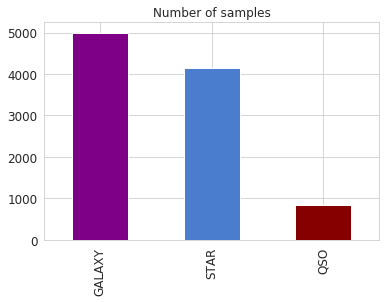

In [5]:
sdss_data['class'].value_counts()
star_color='#4a7dce'
galaxy_color='#7e0087'
qso_color='#870000'
array_color=[star_color, galaxy_color, qso_color]
sdss_data['class'].value_counts().plot(kind='bar',title='Number of samples', color=['#7e0087','#4a7dce','#870000']);

Większość próbek jest skategoryzowanych jako galaktyka (~50%), drugą najlicznijeszą kategorią są gwiazdy (~40%) a kwazary stanowią najmniej liczną grupę (~10%).

## Brakujące wartości

In [6]:
columns = sdss_data.columns
percent_missing = sdss_data.isnull().sum() * 100 / len(sdss_data)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing')

column_name  percent_missing
objid           objid              0.0
plate           plate              0.0
redshift     redshift              0.0
class           class              0.0
specobjid   specobjid              0.0
field           field              0.0
camcol         camcol              0.0
rerun           rerun              0.0
run               run              0.0
z                   z              0.0
i                   i              0.0
r                   r              0.0
g                   g              0.0
u                   u              0.0
dec               dec              0.0
ra                 ra              0.0
mjd               mjd              0.0
fiberid       fiberid              0.0

Jak widać nie brakuje żadnych wartośći, co oznacza, że nie musimy ani usuwać ani dodawać wartości do naszego zbioru danych.

## Filtracja danych

Już na tym etapie możemy określić, które cechy nie będą w jakikolwiek sposób powiązane z zmienną onjaśnianą.

objid oraz specobjid są jedynie identyfiatorami, które były używane do identyfikacji rekordów kiedy jeszcze znajdowały się w bazie danych. Dlatego też nie będziemy ich brać pod uwagę podczas klasyfikacji.

Co więcej, cechy: 'run', 'rerun', 'camcol' oraz 'field' są cechami opisującymi części aparatu w momencie pomiaru obserwacji.

Źródło: http://www.sdss3.org/dr9/imaging/imaging_basics.php

W związku z powyższym usuniemy wyżej wymienione kolumny, gdzyż jakikolwiek związek z klasą przynależności byłby przypadkowy.

In [7]:
print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_data.head(1)

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


ra       dec         u        g         r         i         z  \
0  183.531326  0.089693  19.47406  17.0424  15.94699  15.50342  15.22531   

  class  redshift  plate    mjd  fiberid  
0  STAR -0.000009   3306  54922      491

## Wizualizacja danych

In [8]:
train_set, test_set = train_test_split(sdss_data, test_size=0.2, random_state=42)

In [9]:
test_set.head()

ra        dec         u         g         r         i         z  \
6252  134.649267  54.386344  18.81835  16.92881  16.01003  15.60394  15.28167   
4684  157.095224  62.597393  19.34686  19.26424  19.23350  19.16362  19.01978   
1731  159.606276  -0.017860  18.19884  16.96567  16.48693  16.26755  16.16388   
4742  179.301596  -3.352143  18.58485  16.94794  16.12376  15.68609  15.39742   
4521  169.483809  67.664549  17.87708  16.62665  16.14410  15.96780  15.89828   

       class  redshift  plate    mjd  fiberid  
6252  GALAXY  0.084596    449  51900      538  
4684     QSO  2.066336   7090  56659      776  
1731  GALAXY  0.019085    274  51913      277  
4742  GALAXY  0.082017    331  52368      283  
4521    STAR -0.000302   2858  54498      323

### Histogramy

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe201d3048>,
      dtype=object)

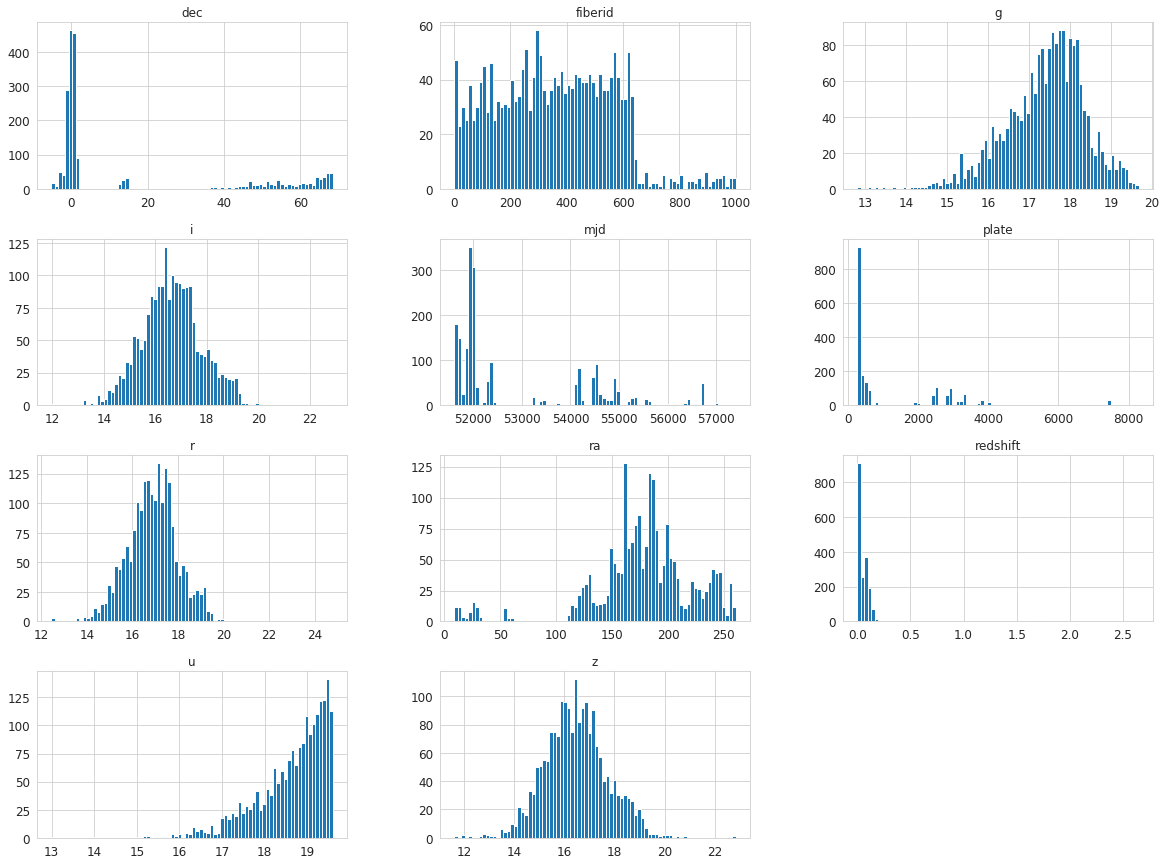

In [10]:
test_set.hist(bins=80, figsize=(20,15))

## Analiza uniwariatywna

### Redshift

By przeprowadzić analizę uniwariatywną zaczniemy od histogramów dla cechy 'redshift' dla każdej z klas. Powie nam to w jaki sposób przesunięcie ku czerwieni jest zdystrybuowane wśród klas.

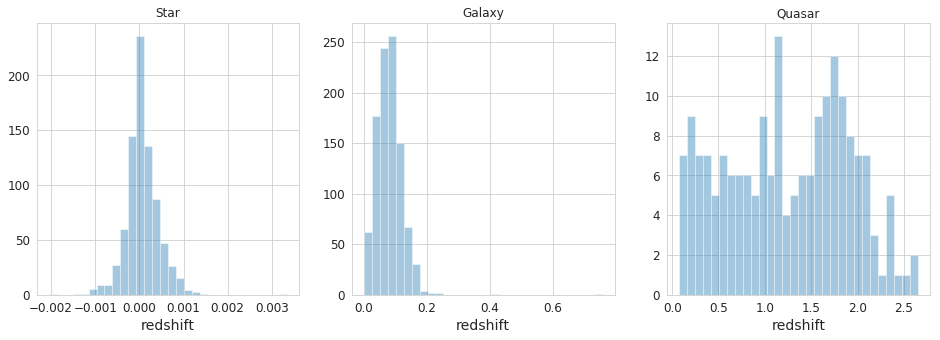

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 5))
ax = sns.distplot(test_set[test_set['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(test_set[test_set['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(test_set[test_set['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

Widzimy, że wartości przesunięcia ku czerwieni znacząco różnią się pośród klas. 

* Gwiazdy - widzimy, że histogram przypomina rozkład normalny o średniej u=0
* Galaktyki - tutaj wartości wydają się pochodzić z rozkładu normalnego o nieco cięższym prawym ogonie. Rozkład ten ma średnią wartść wokół punktu 0.075.
* Kwazary - wrtości przesunię cia ku czerwieni są o wiele bardziej jednorodnie rozproszone, niż w przypadku gwiazd i galaktyk. Są one mniej więcej równo rozproszone w przedziale od 0 do 3, póżniej ich występowanie zdaje się zanikać drastycznie. Blisko wartości 4 i 5 mamy parę wartości odstających.

### Rektascensja

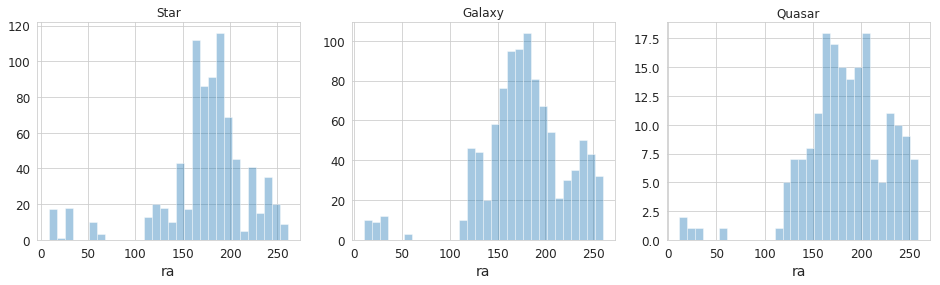

In [12]:
# Right Ascension
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(test_set[test_set['class']=='STAR'].ra, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(test_set[test_set['class']=='GALAXY'].ra, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(test_set[test_set['class']=='QSO'].ra, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

TODO Wnioski

### Deklinacja

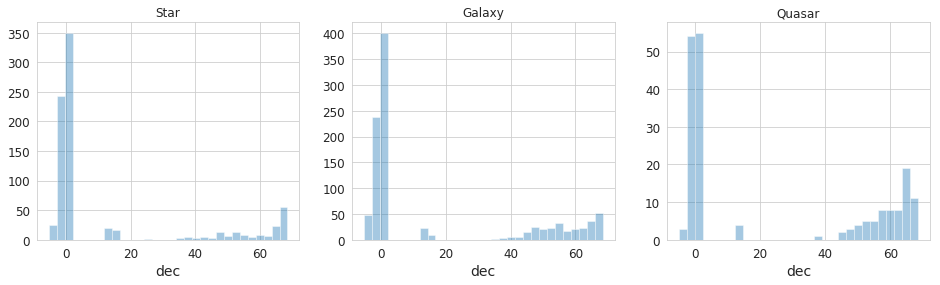

In [13]:
# Declination
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(test_set[test_set['class']=='STAR'].dec, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(test_set[test_set['class']=='GALAXY'].dec, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(test_set[test_set['class']=='QSO'].dec, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

TODO Wnioski

### U

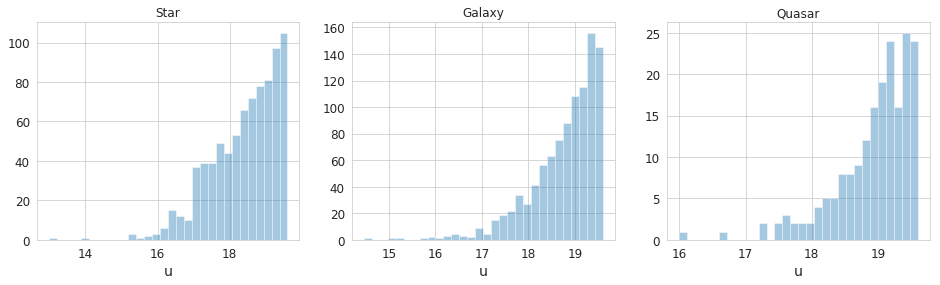

In [14]:
# U
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(test_set[test_set['class']=='STAR'].u, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(test_set[test_set['class']=='GALAXY'].u, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(test_set[test_set['class']=='QSO'].u, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

TODO Wnioski

### G

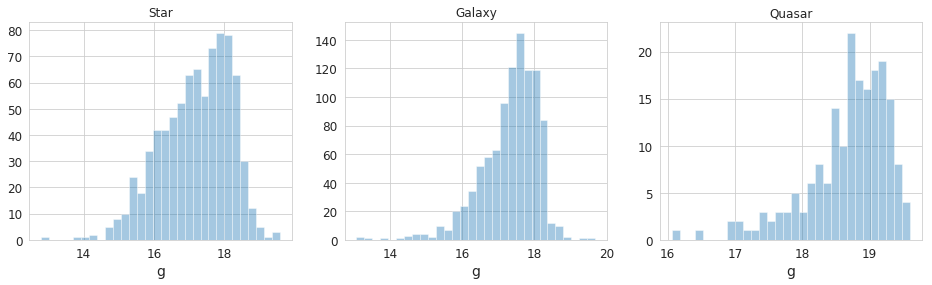

In [15]:
# G
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(test_set[test_set['class']=='STAR'].g, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(test_set[test_set['class']=='GALAXY'].g, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(test_set[test_set['class']=='QSO'].g, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

TODO Wnioski

### R

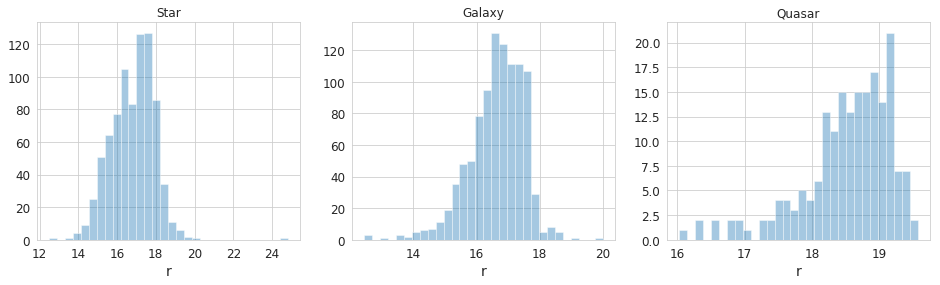

In [16]:
# R
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(test_set[test_set['class']=='STAR'].r, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(test_set[test_set['class']=='GALAXY'].r, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(test_set[test_set['class']=='QSO'].r, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

TODO Wnioski

### I

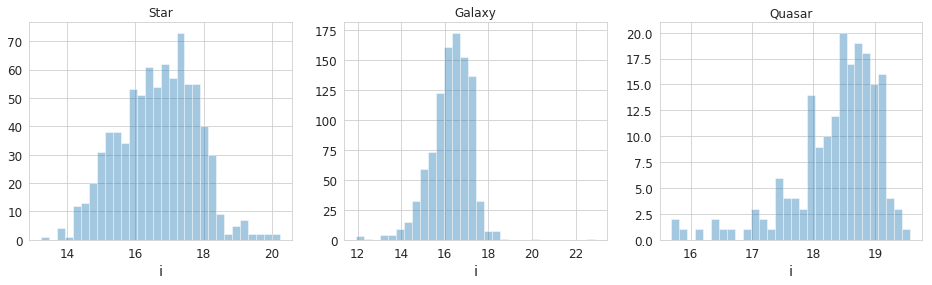

In [17]:
# I
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(test_set[test_set['class']=='STAR'].i, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(test_set[test_set['class']=='GALAXY'].i, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(test_set[test_set['class']=='QSO'].i, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

TODO Wnioski

### Z

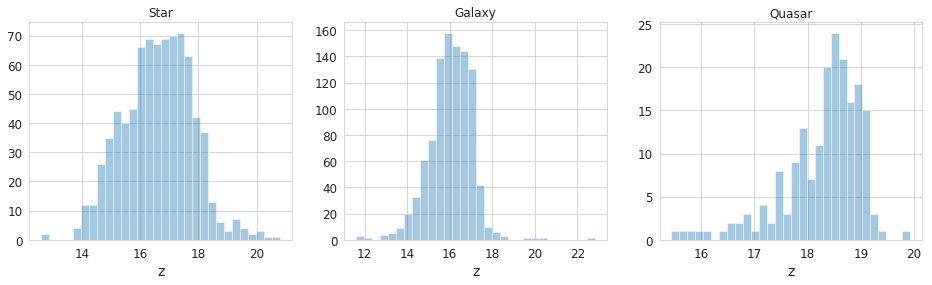

In [18]:
#Z
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(test_set[test_set['class']=='STAR'].z, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(test_set[test_set['class']=='GALAXY'].z, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(test_set[test_set['class']=='QSO'].z, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

TODO Wnioski

### Plate

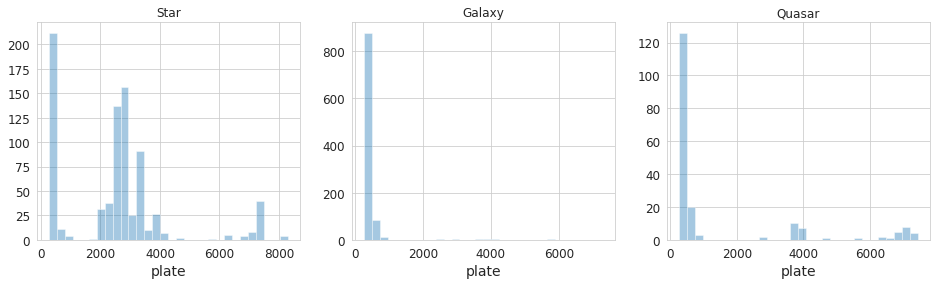

In [19]:
# Plate
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(test_set[test_set['class']=='STAR'].plate, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(test_set[test_set['class']=='GALAXY'].plate, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(test_set[test_set['class']=='QSO'].plate, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

TODO Wnioski

### MDJ

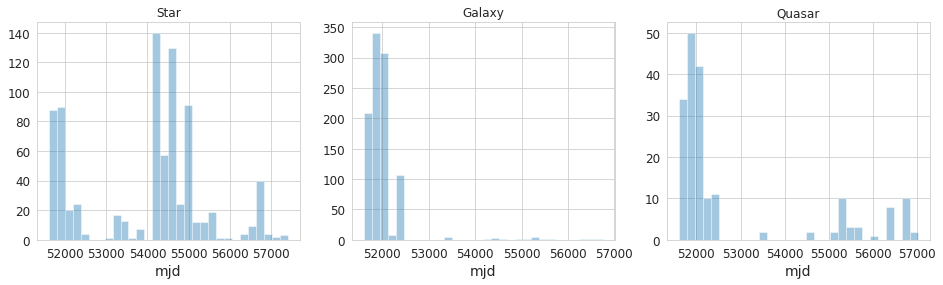

In [20]:
# MDJ
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(test_set[test_set['class']=='STAR'].mjd, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(test_set[test_set['class']=='GALAXY'].mjd, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(test_set[test_set['class']=='QSO'].mjd, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

TODO Wnioski

### FiberID

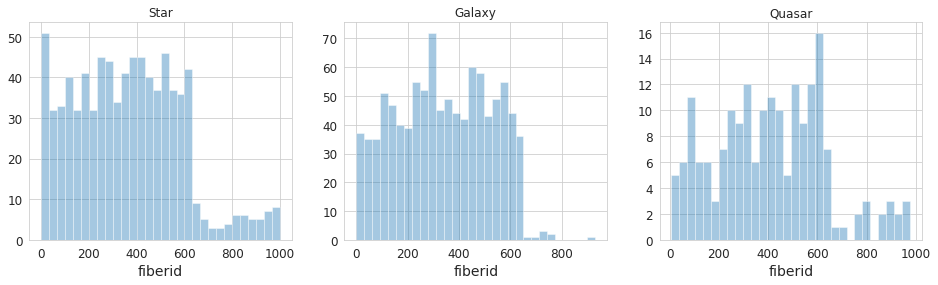

In [21]:
# FiberID
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

ax = sns.distplot(test_set[test_set['class']=='STAR'].fiberid, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(test_set[test_set['class']=='GALAXY'].fiberid, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(test_set[test_set['class']=='QSO'].fiberid, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Quasar')

TODO Wnioski

## Scatter plot

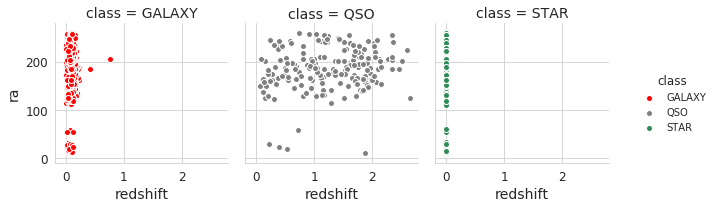

In [22]:
# Modify the graph above by assigning each species an individual color.
g = sns.FacetGrid(test_set, hue="class", col="class", margin_titles=True,
                  palette={"GALAXY":"red", "STAR":"seagreen", "QSO":"gray"})
g = g.map(plt.scatter, "redshift", "ra",edgecolor="w").add_legend();

## Box plot

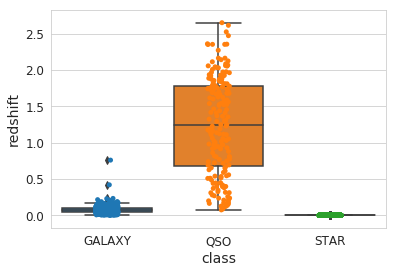

In [23]:
ax= sns.boxplot(x="class", y="redshift", data=test_set)
ax= sns.stripplot(x="class", y="redshift", data=test_set, jitter=True, edgecolor="gray")
plt.show()

## Multivatiative plot

<Figure size 432x288 with 0 Axes>

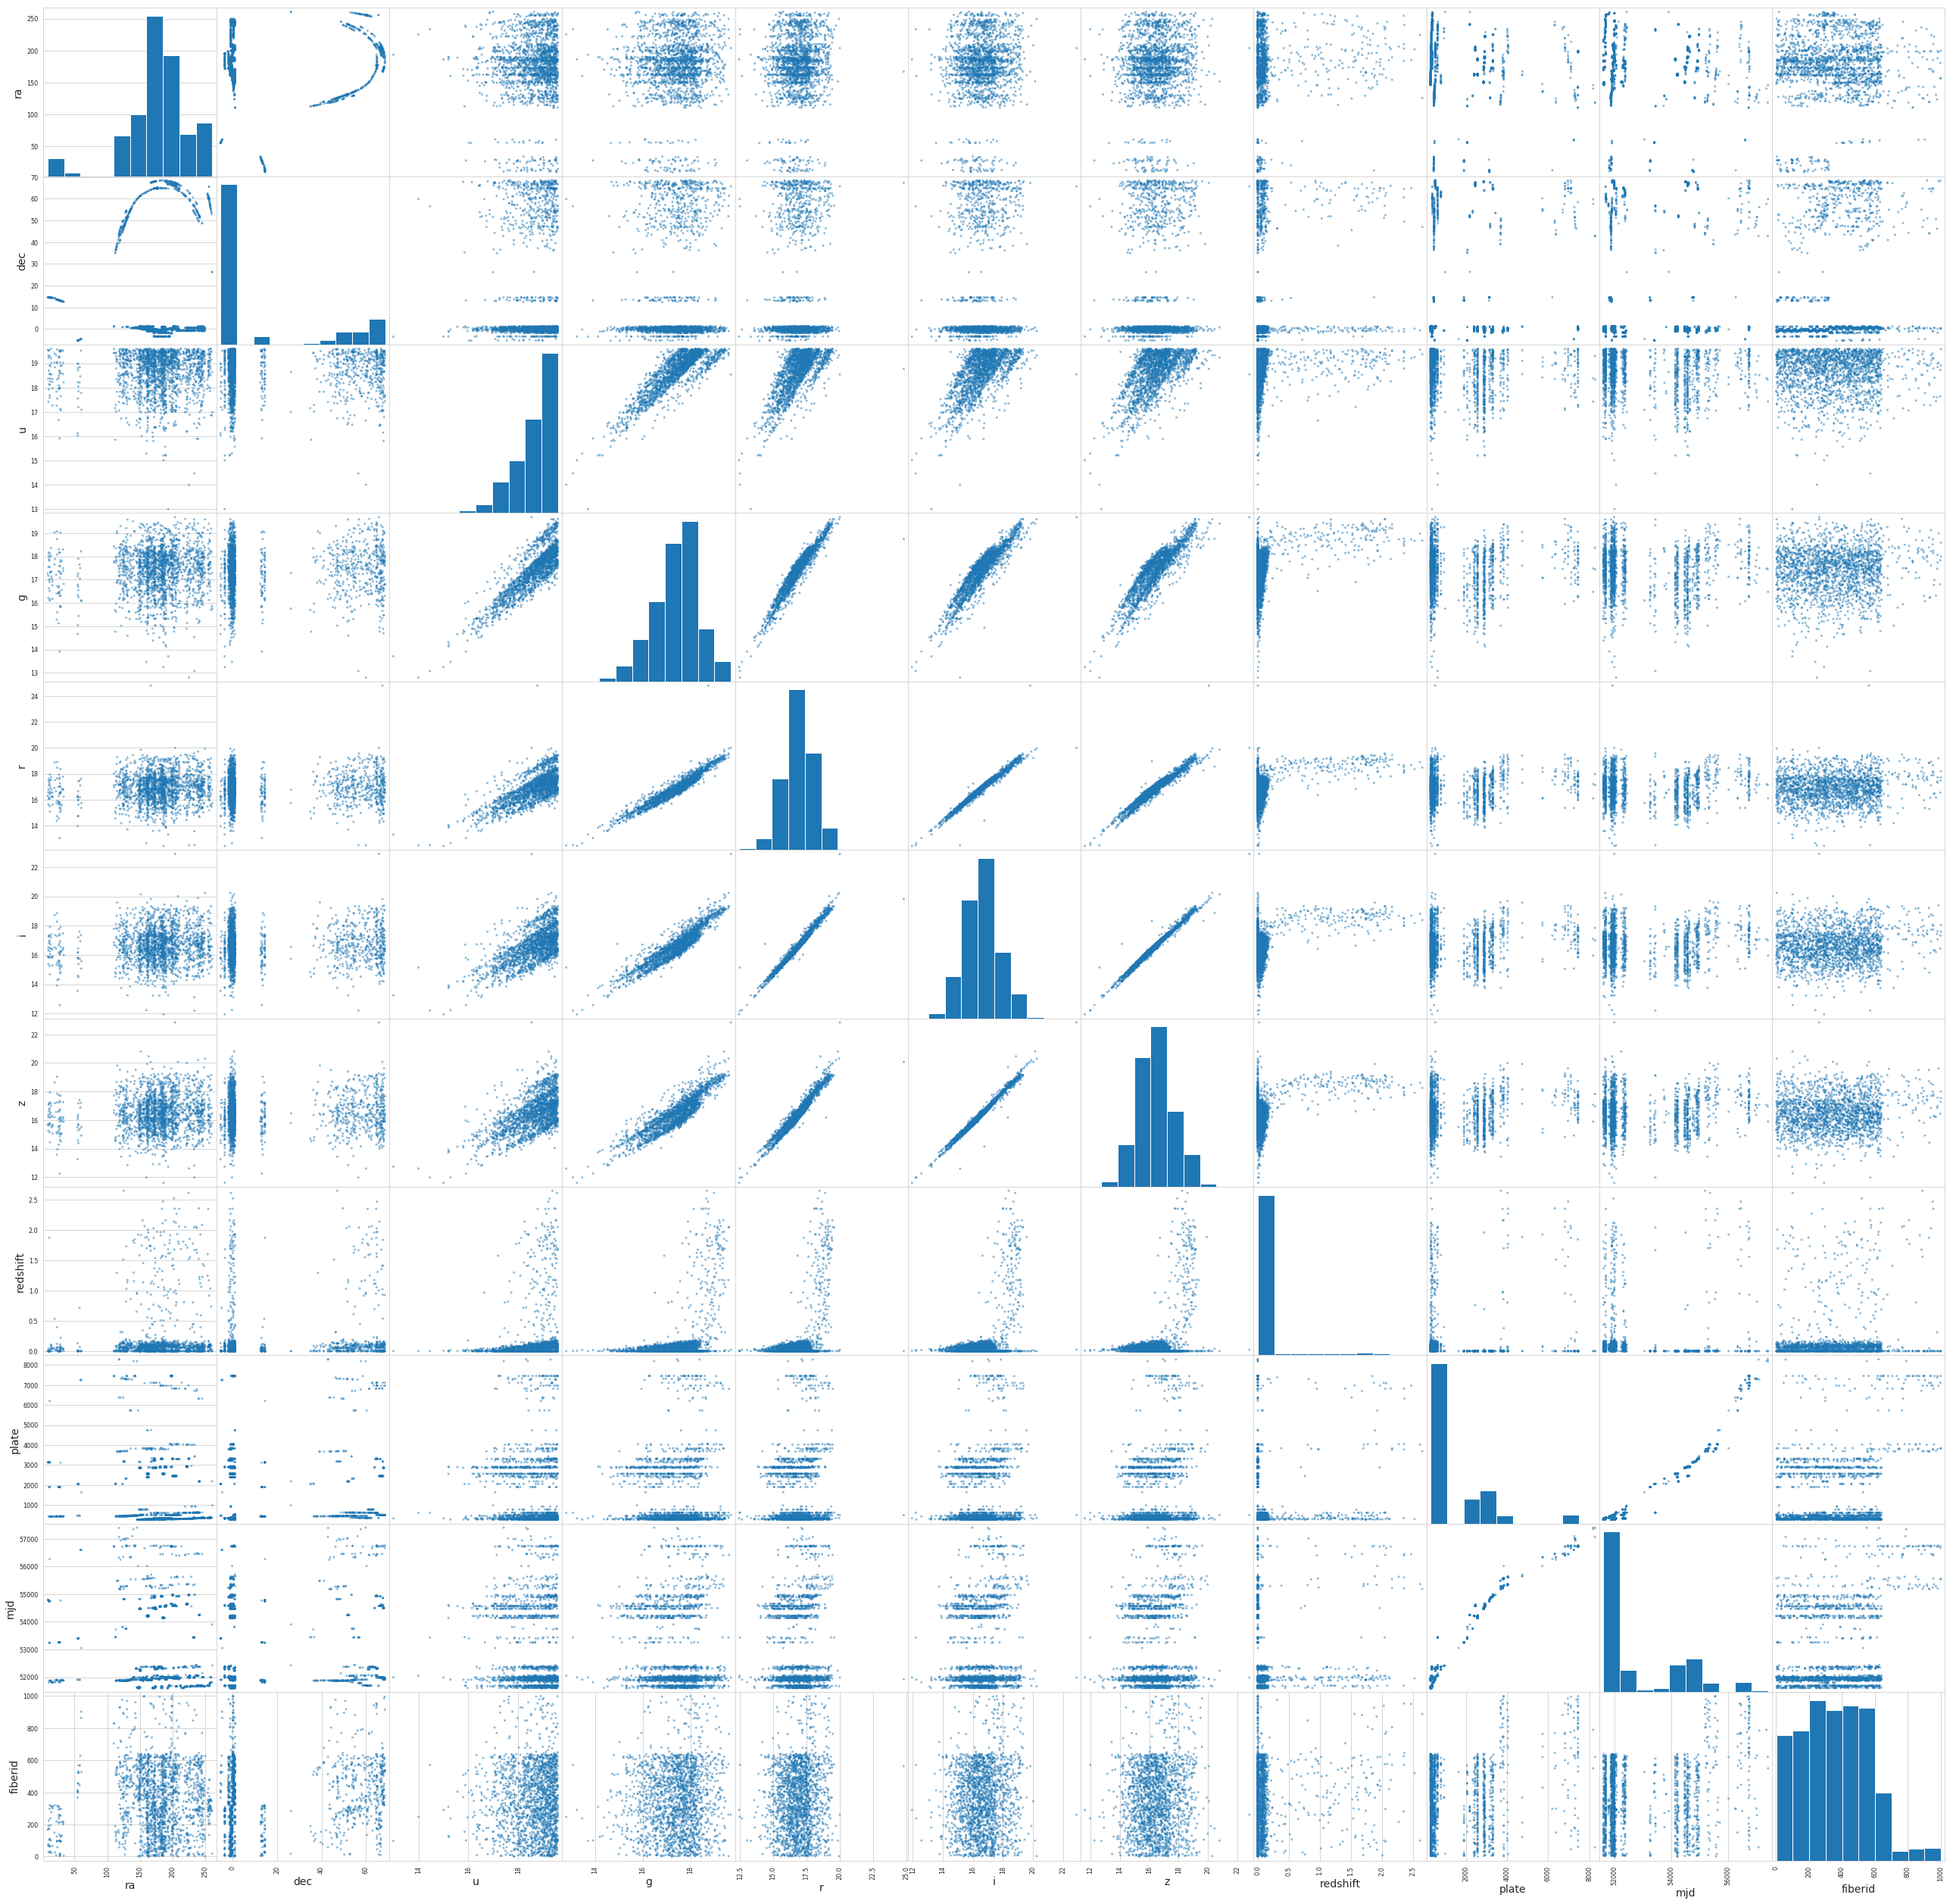

<Figure size 432x288 with 0 Axes>

In [36]:
# scatter plot matrix
pd.plotting.scatter_matrix(test_set,figsize=(45,45))
plt.figure()

Note the diagonal grouping of some pairs of attributes. This suggests a high correlation and a predictable relationship.

## Pairplot

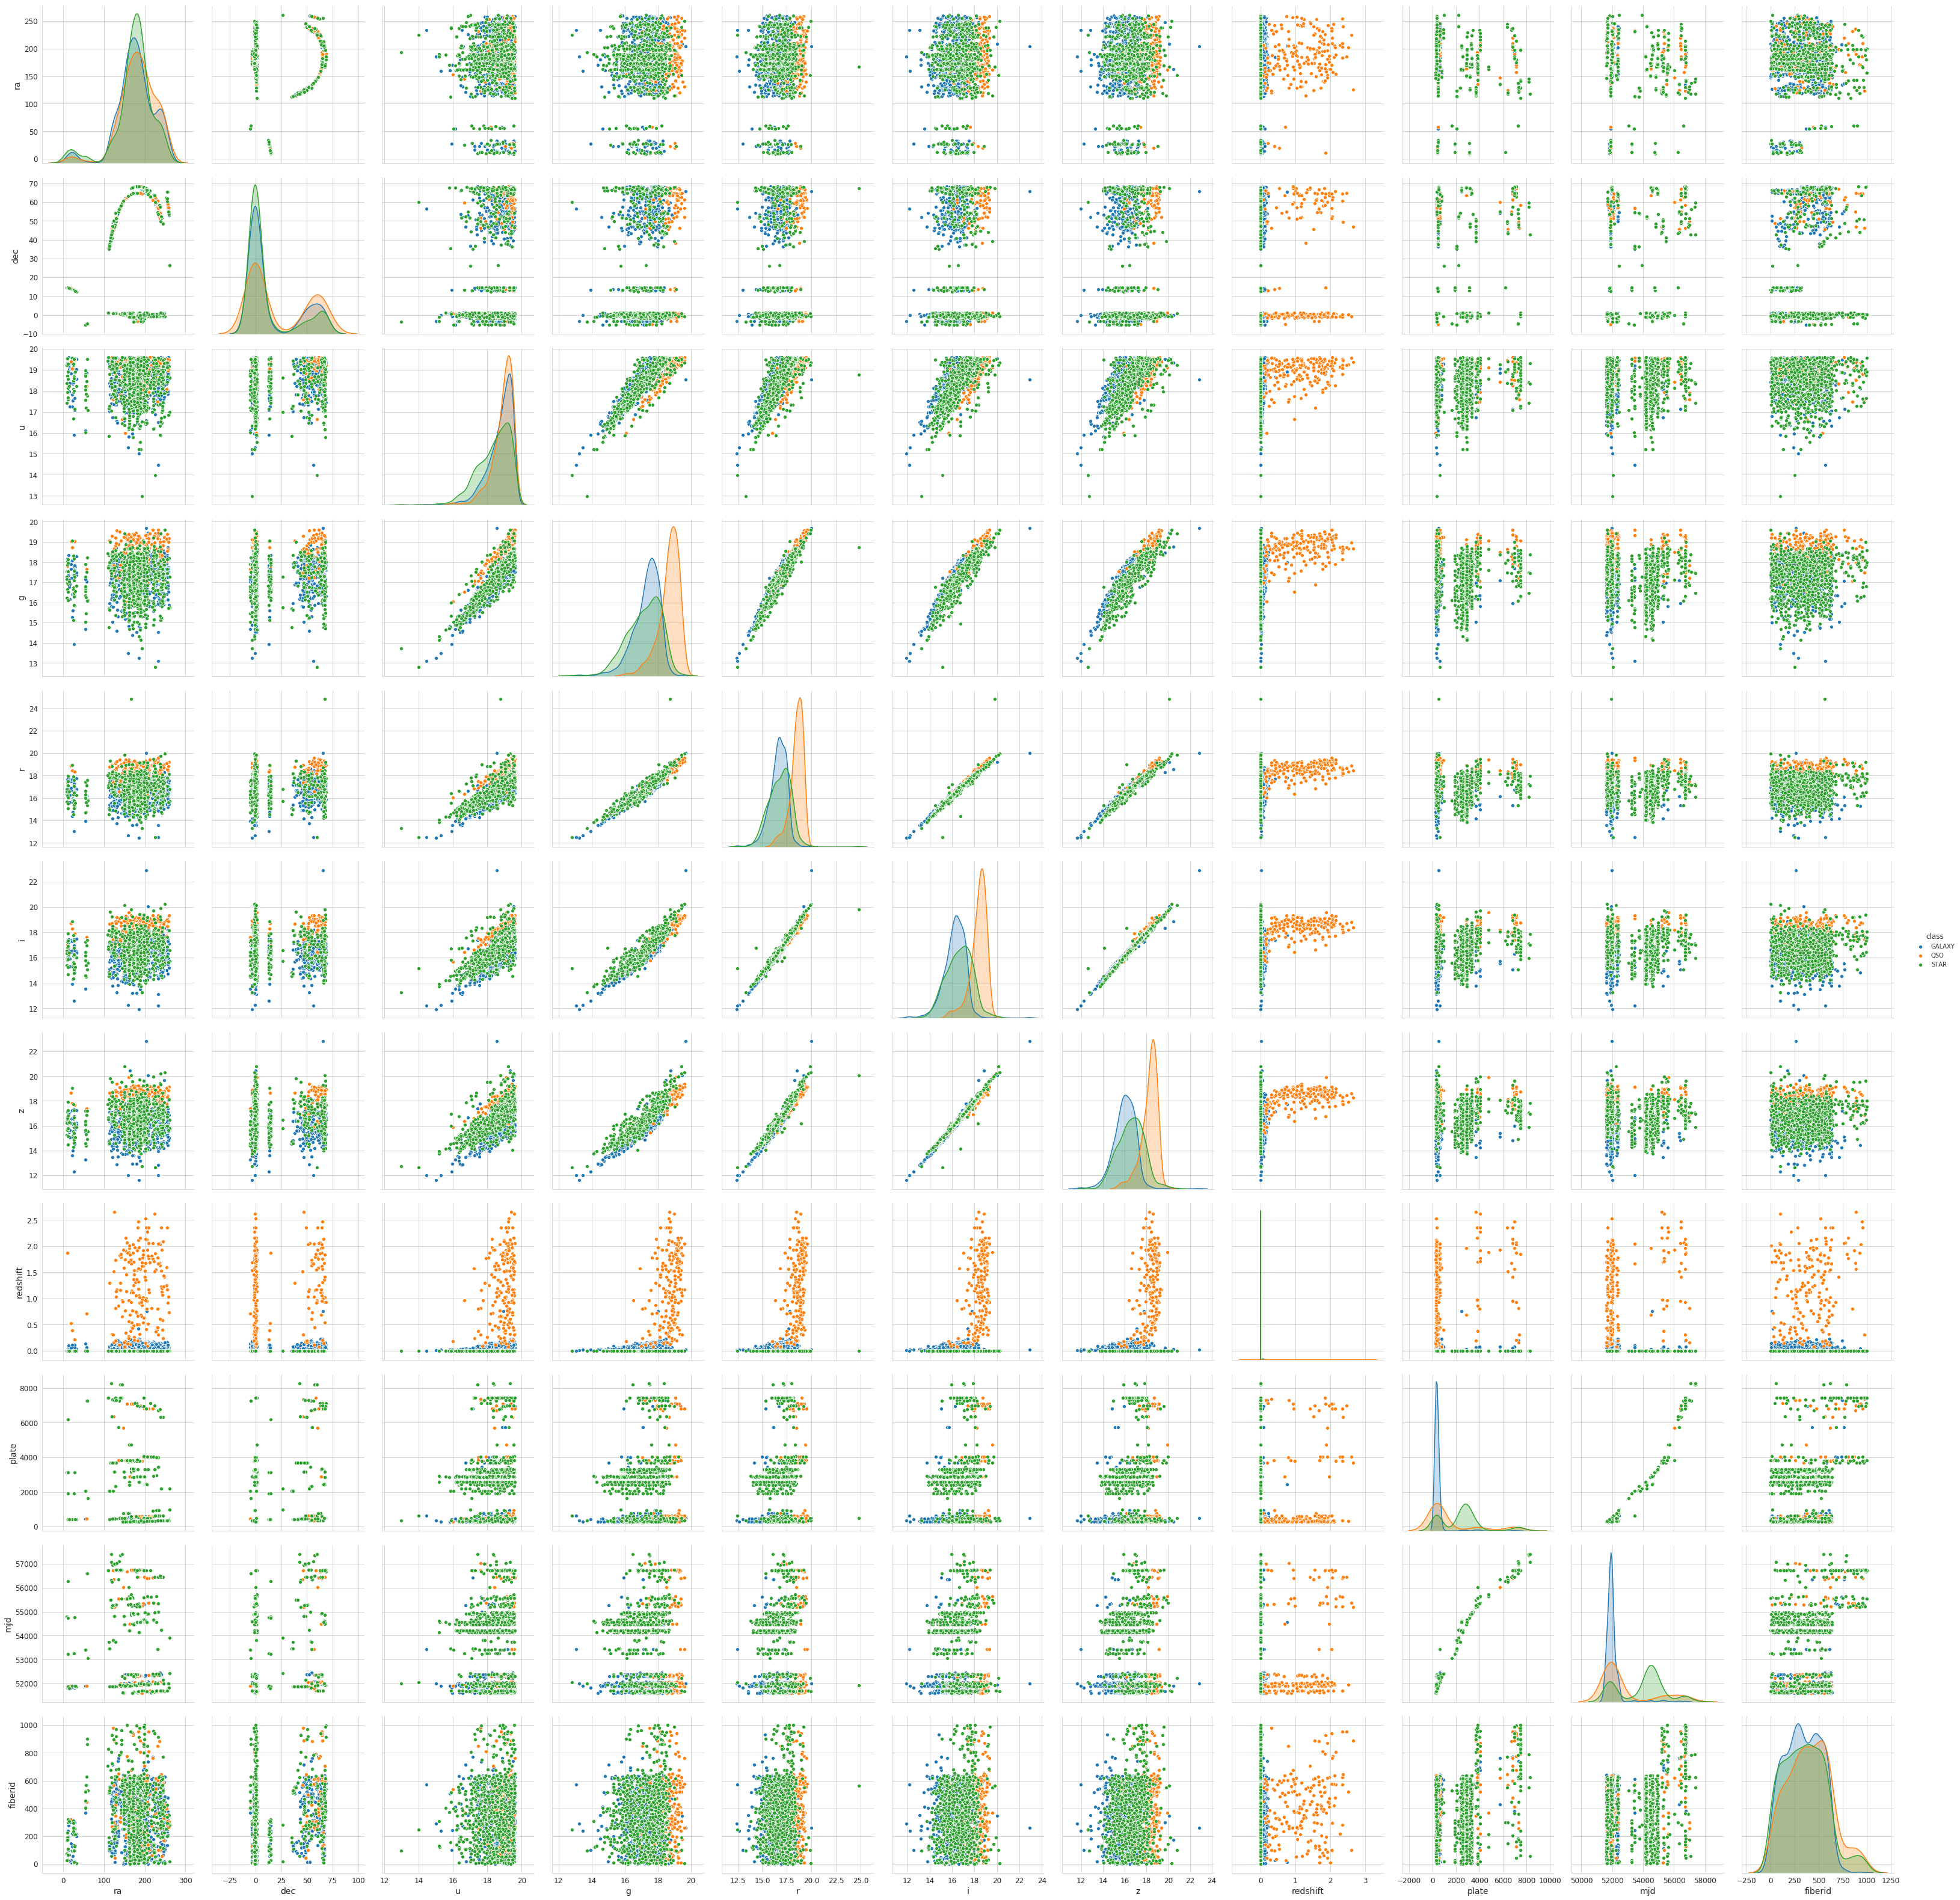

In [38]:
# Using seaborn pairplot to see the bivariate relation between each pair of features
sns.pairplot(test_set, hue="class", height=4)

### Korelacja zmiennych

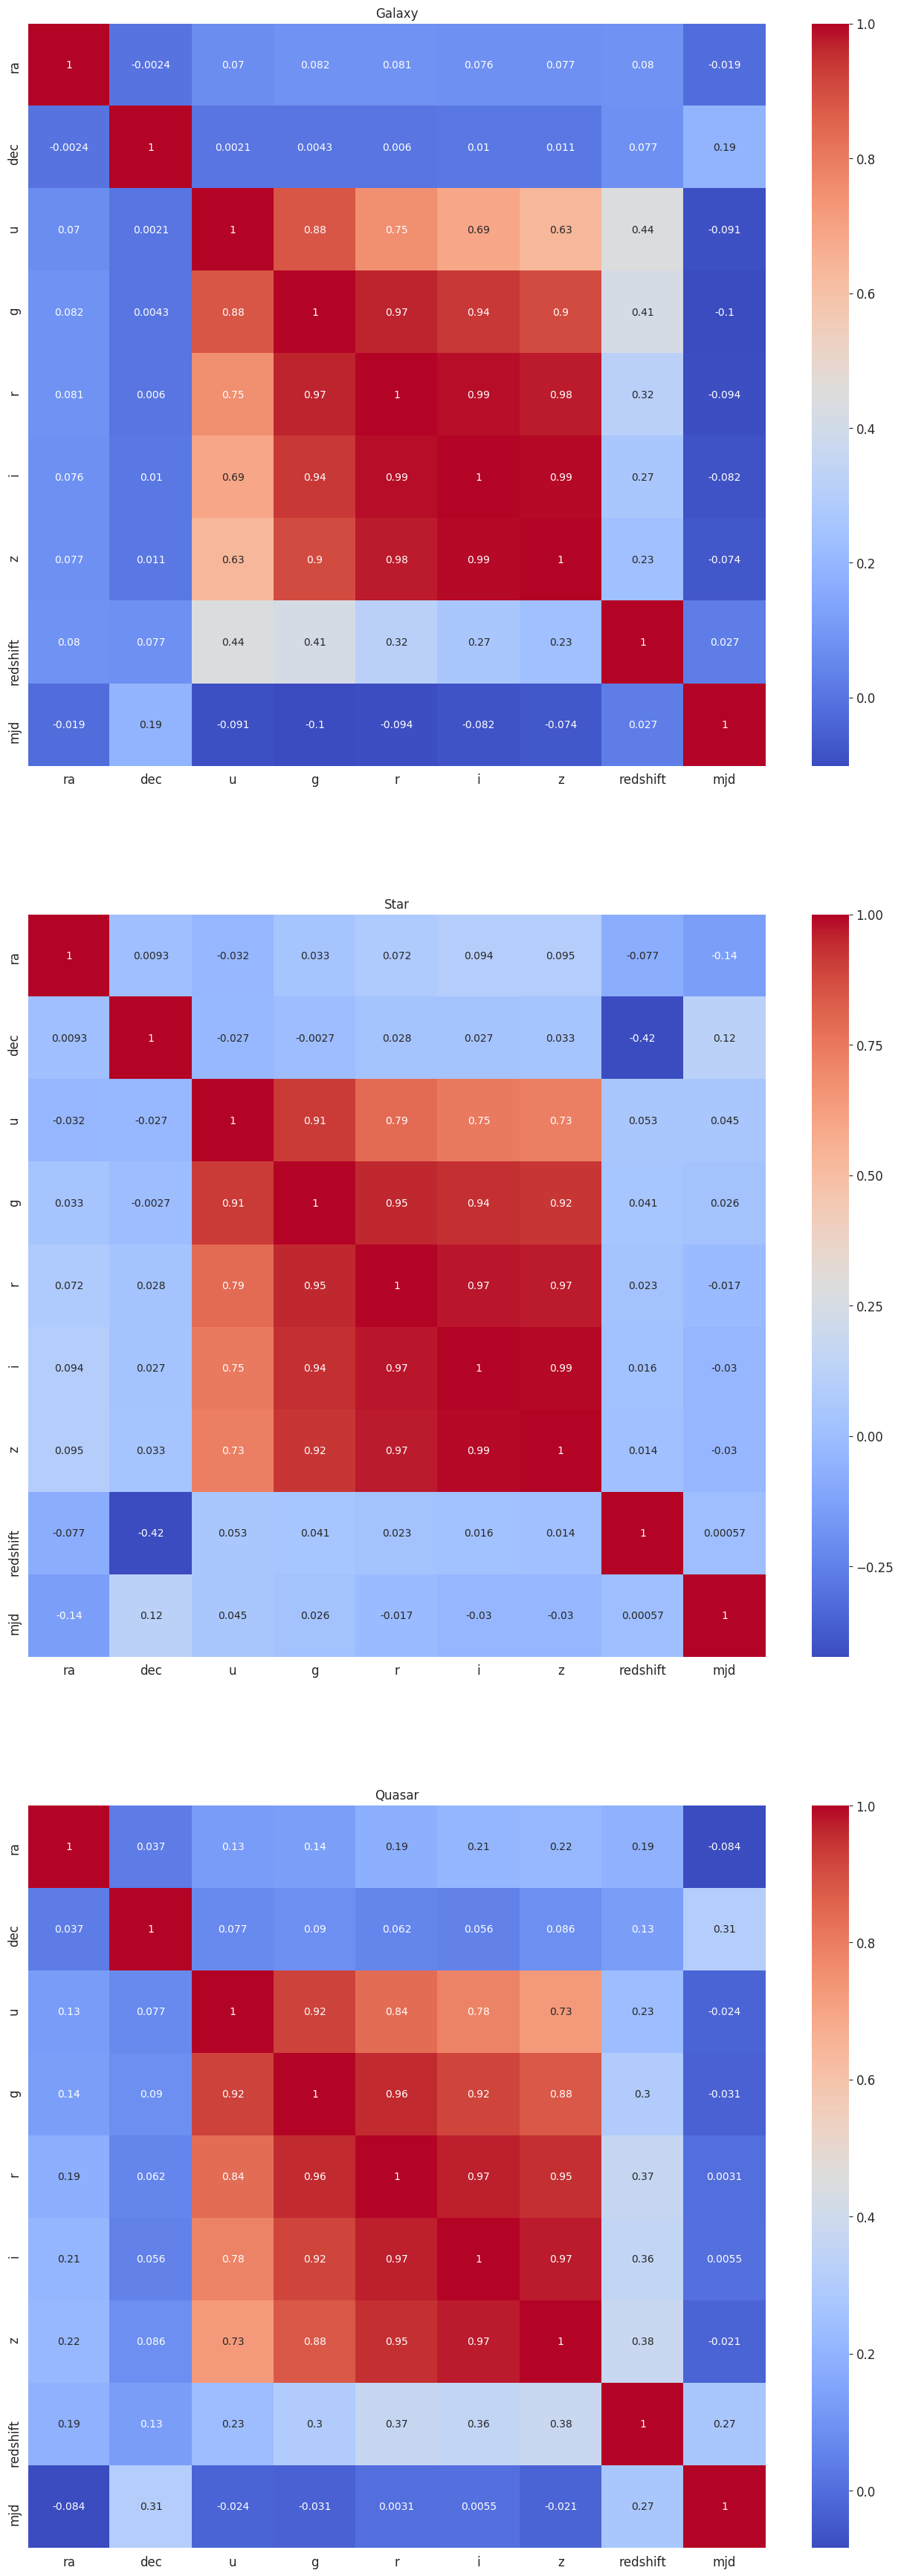

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(16, 45))
fig.set_dpi(100)
ax = sns.heatmap(test_set[test_set['class']=='GALAXY'][['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift', 'mjd']].corr(), ax = axes[0], cmap='coolwarm', annot=True)
ax.set_title('Galaxy')
ax = sns.heatmap(test_set[test_set['class']=='STAR'][['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift', 'mjd']].corr(), ax = axes[1], cmap='coolwarm', annot=True)
ax.set_title('Star')
ax = sns.heatmap(test_set[test_set['class']=='QSO'][['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift', 'mjd']].corr(), ax = axes[2], cmap='coolwarm', annot=True)
ax = ax.set_title('Quasar')